In [1]:
import torch
import pandas as pd
import numpy as np
# pip install transformers
from transformers import BertTokenizer, BertModel
# 만약 주피터 노트북에서 아래와 관계있는 에러가 발생한다면
# pip install ipywidgets

In [2]:
main_df = pd.read_csv('/opt/ml/input/data/train/train_ratings.csv') # user-item-time

In [3]:
# genre_df 생성
genre_df = pd.read_csv("/opt/ml/input/data/train/genres.tsv", sep="\t")
array, index = pd.factorize(genre_df["genre"])
genre_df["genre"] = array # item-genre(number)

# Genre Embedding

한 영화에 여러개의 장르가 있다.  
장르는 각각의 성질을 가지고 있다고 가정하고 (ex: "액션"과 "범죄"의 거리는 "액션"과 "드라마"의 거리보다 가깝다)  
각 단어들을 임베딩하여 숫자로 표현한다.
이때 각 단어는 크기가 약 760인 벡터로 임베딩 되는데 이 760개의 성분의 평균을 <U>**장르의 임베딩값**</U>으로 설정했다

여러 장르를 동시에 갖는 영화는 해당 장르들의 임베딩 값의 평균으로 설정하였다

In [4]:
# Load the BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

genre_vectors = {} # 각 장르의 임베딩 dict

# Tokenize a genre
for i,j in enumerate(genre_df['genre'].unique()):
    input_ids = torch.tensor(tokenizer.encode(f"{j}")).unsqueeze(0)  # Tokenize a genre
    output = model(input_ids)[0]  # Extract the hidden states of the model at the last layer, The last layer hidden states
    token_embedding = output[0][0]  # Extract the first token's embedding
    np_token_embedding = token_embedding.detach().numpy() # convert to numpy
    v = np_token_embedding.mean()
    genre_vectors[i] = v

ref_genre_dict = {} # 각 영화가 어떤 장르를 가지고 있는지 나타내는 dict
for i, j in list(zip(genre_df['item'], genre_df['genre'])):
    try:
        ref_genre_dict[i].append(j)
    except KeyError:
        ref_genre_dict[i] = [j]

genre_df_dict = {} # 각 영화의 장르 통합 임베딩 dict
for i, j in list(zip(ref_genre_dict.keys(), ref_genre_dict.values())):
    genre_df_dict[i] = 0
    for k in j:
        genre_df_dict[i] += genre_vectors[k]
    genre_df_dict[i] = (genre_df_dict[i])/len(j)

# # 데이터 프레임에 적용
# ref_df = main_df.copy()
# ref_df['item_2'] = ref_df['item']
# ref_df.item_2 = ref_df.item_2.map(genre_df_dict)
# ref_df = ref_df.rename(columns={'item_2':'genre_embedding'})
# ref_df

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
result = [(item, embedding) for item, embedding in genre_df_dict.items()]

In [6]:
result_df = pd.DataFrame(result)

In [7]:
result_df.columns = ['item', 'genre_embedding']

In [8]:
result_df.to_csv(
    "genre_bert_fe.csv", index=False
)

# genre_embedding 결과를 10개의 카테고리로 나누기

In [ ]:
# genre_bert_fe 파일이 있다면 바로 read_csv를 해도 된다.
result_df = pd.read_csv("/opt/ml/input/fighting/FE/genre/genre_bert_fe.csv")

In [9]:
result_df['genre_embedding'].describe()

count    6807.000000
mean       -0.010407
std         0.000238
min        -0.011394
25%        -0.010508
50%        -0.010369
75%        -0.010281
max        -0.010054
Name: genre_embedding, dtype: float64

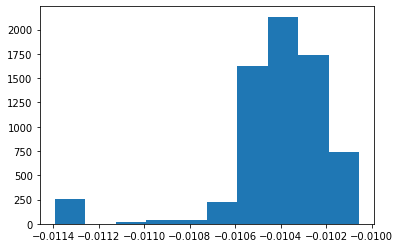

In [29]:
import matplotlib.pyplot as plt

# 실수 리스트
values = list(result_df['genre_embedding'])

# 히스토그램 그리기
plt.hist(values)
plt.show()

In [30]:
def genre_eight_category(x):
    if x <= -0.0112:
        return 0
    elif x <= -0.0110:
        return 1
    elif x <= -0.0108:
        return 2
    elif x <= -0.0106:
        return 3
    elif x <= -0.0104:
        return 4
    elif x <= -0.0102:
        return 5
    else:
        return 6

In [32]:
result_df['genre_embedding'].map(genre_eight_category).value_counts()

5    3236
4    2221
6     778
0     257
3     237
2      56
1      22
Name: genre_embedding, dtype: int64

In [33]:
result_df['genre_category'] = result_df['genre_embedding'].map(genre_eight_category)

In [34]:
result_df

,item,genre_embedding,genre_category
0,318,-0.010337,5
1,2571,-0.010408,4
2,2959,-0.010351,5
3,296,-0.010276,5
4,356,-0.010311,5
...,...,...,...
6802,73106,-0.010054,6
6803,109850,-0.010343,5
6804,8605,-0.010205,5
6805,3689,-0.010054,6


In [37]:
result_df

,item,genre_embedding,genre_category
0,318,-0.010337,5
1,2571,-0.010408,4
2,2959,-0.010351,5
3,296,-0.010276,5
4,356,-0.010311,5
...,...,...,...
6802,73106,-0.010054,6
6803,109850,-0.010343,5
6804,8605,-0.010205,5
6805,3689,-0.010054,6


In [38]:
result_df[['item','genre_category']].to_csv(
    "genre_bert_category_fe.csv", index=False
)